# 데이터 불러오기

In [1]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2023-08-16 06:41:40--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.1’

ratings_train.txt.1 100%[===================>]  13.95M  --.-KB/s    in 0.09s   

2023-08-16 06:41:40 (155 MB/s) - ‘ratings_train.txt.1’ saved [14628807/14628807]

--2023-08-16 06:41:41--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Sa

In [57]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece as spm

import html # HTML 엔티티 인코딩
import re
import string

In [81]:
train_df = pd.read_csv('ratings_train.txt', sep='\t')

train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 네이버 영화 평점 데이터
- 데이터 형식
    - tsv 파일 형식
- 항목
    - id
        - 레코드 고유키
    - document
        - 영화 한줄평 리뷰
    - label
        - 평점에 따른 감정 라벨링
            - 1\~4점: 부정적, 9\~10점: 긍정적
            - 5\~8점은 제외
        - 긍정적(1)/부정적(0)
- 데이터셋
    - train
        - 150,000개
    - test
        - 50,000개
    - 모든 데이터셋에 긍정적/부정적 리뷰가 절반씩 포함됨
    - 모든 리뷰는 140자 이내

In [82]:
train_df = train_df.dropna()
train_df = train_df.drop_duplicates(subset=['document'])

corpus = train_df['document']
labels = train_df['label']
    
print("훈련 데이터 개수:", len(corpus))

훈련 데이터 개수: 146182


# 데이터 분석

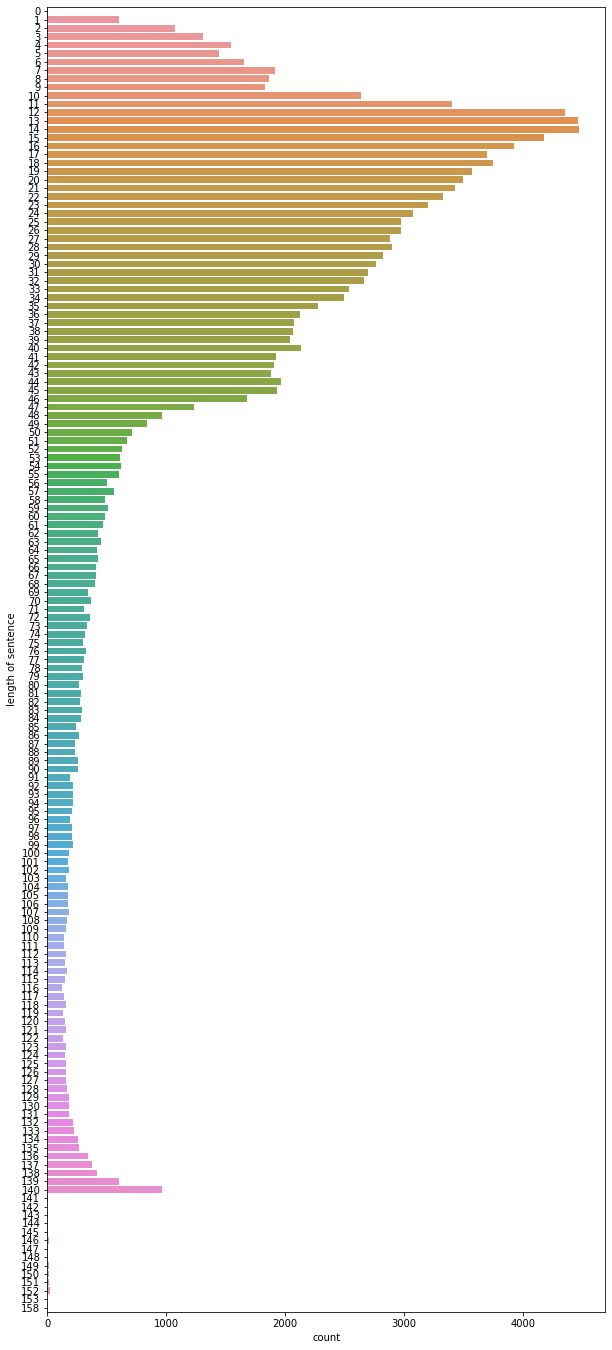

In [83]:
corpus = corpus.astype('str')
lenghts = corpus.apply(len)

_, ax = plt.subplots(figsize=(10, 24))

sns.countplot(y=lengths, ax=ax)
plt.ylabel('length of sentence')
plt.xlabel('count')
plt.show()

- 13자, 14자 리뷰가 가장 많다
- 데이터셋 설명에 140자 이내 데이터라고 했음에도 불구하고 140자가 넘는 데이터가 존재
- 0자 리뷰도 존재

In [84]:
for text in filter(lambda x: len(x) > 140, corpus):
    print(len(text), text)

144 "상처투성이인 한국인을 위하여 어제는 추기경님이 계셨고 오늘은 교황님께서 치유하시고 가셨습니다. "" 고난이 나를 찾을때 피하고 싶은 내마음은""하시며 노래부르실때는 한 인간으로서 사제로서 격었을 그분의 고난에 눈물이 흐릅니다. 이땅에 이런어른 더안계시나요"
141 "가슴이 먹먹하고 반전으로 약간의 혼란스러움속에서도 인간적으로 잘 마무리하네요 특히 영화의 모든 장면에 연관된 의미가 가득해서 끝나고 나후 ""그래서~""라는 생각을 들게 하는 영화입니다. 막판 아스카의 마음이 그대로 읽혀지는 가슴저린 영화!!강추!!"
143 "배우들 연기 :10점, 연출 :10점 , 스토리 : 10노잼 .. 내용이 짜집기가 안될거같을때 주인공이 ""이건현실이 아니야!!"" 한마디하면서 게속 얼렁뚱땅 넘어가는느낌? 보는데 진짜 찝찝;; 내용이 앞뒤는 안맞고 뭐 자꾸 이건현실이 아니라면서넘어가니"
141 "대구에선 몇OO간 유명한 사건이었다나도 초등학교때부터 담배각 학교포스터에 있던 애들이라 관심도 많았고 꼭 보고싶던 영화였다근데 시작하자마자 ""여보세요""하는 순간 감정이입 실패 대구사람들은 알겠지만 전부 부산 사투리를 쓰고있었다 감독의 능력을 알수"
144 "이제 어른들이 어떻게 하면 좋을까? 라는 대사에서 느껴지는 무책임. 담임이 자신의 딸에게 ""무책임? 그런 건 몰라!"" 에서 느껴지는 이중적인 모습에 소름 돋았다. 서바이벌 게임을 통해 그려진 그림 또한 실제 학급 모습과 크게 다르지 않다는 생각도..b"
144 "연출은 물론 배우들의 연기력 등 모든것이 완벽한 영화.모건 프리먼의 목소리가 영화의 몰입도를 더욱 높였다.""태평양이 내 꿈에서처럼 푸르기를 희망한다.나는 희망한다.""이 대사가 너무 좋았다ㅠ희망이라는 추상적인 명사에 대해 다시 생각하게되는 계기가 되었다"
144 "윤시윤,서재희역할 너무 머찌고 연기짱이였습니다.정말 몰입해서 잘 봤어요. 윤시윤배우의 가능성이 엿보이고, 이지아씨랑 연기호흡도 너무 좋았습니다. 어려운 상황에 좋은 작품 감동 적입니다. 이제 마

- 140자를 초과하는 리뷰
    - ""
        - 문장 앞뒤로 존재
        - 큰따옴표에도 붙음
    - HTML 문자 엔티티도 문자 그대로 들어감
        - &gt가 한글자가 아니라 세글자로 인식
- 처리방법
    - HTML 엔티티를 전부 인코딩한 후 일부 문장부호를 제외한 특수기호는 전부 제거

In [86]:
for text in filter(lambda x: len(x) > 140, corpus):
    text = html.unescape(text)
    text = text.replace('""', '')
    if len(text) > 140:
        print(len(text), text) # 엔티티와 세겹큰따옴표를 해결하니 모두 140자 이내로 들어왔다.

# 텍스트 전처리

1. html 엔티티 인코딩
2. 한글, 영문, 숫자, 문장부호를 제외한 문자 제거
3. 중복된 띄어쓰기 지우기
4. 길이가 0인 문장 제거
5. 문장부호 단일 토큰화

In [126]:
def preprocessing(df):
    df['document'] = df['document'].astype('str')
    filters = re.compile('[^ㄱ-ㅎ가-힣a-zA-Z0-9 !\?\.,]')
    
    # html 엔티티 인코딩
    df['document'] = df['document'].apply(html.unescape)
    # 특수문자 제거
    df['document'] = df['document'].apply(lambda s: filters.sub('', s))
    # 중복된 띄어쓰기 지우기
    df['document'] = df['document'].apply(lambda s: re.sub(r'\b{2:}', ' ', s))
    
    df = df[(df['document'].apply(len) > 0) & (df['document'] != ' ')]

    puncs = ["!", "?", ".", ","]
    for p in puncs:
        df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))

    df = df.reset_index()
    _corpus = df['document']
    _labels = df['label']
                                         
    return _corpus, _labels

_corpus, _labels = preprocessing(train_df)
    
print('전처리 후 남은 문장:', len(_corpus))

/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


전처리 후 남은 문장: 146126


In [103]:
import random

for _ in range(20):
    print(_corpus[random.randint(0, len(_corpus))])

네이버 평점 완전 못밌겠네 !  이게 웃겨 ?  ?  ?  나참 . 
죽은 자들이 주인공에게 나타난다는 소재는 그럭저럭 가능성 있지만 ,  감독은 이를 쓰레기로 만든다 . 
영화보다 영화속에 나오는 노래가 더궁금한 영화
조국을 위하여 !  애국자의 표정과 대사가 다소 거북하다 . 
자기가 꼬시고 자기가 복수하고 학규나 덕이나 똑같음포르노를 부드럽게 묘사했을뿐 베드신도 저렇게 적나라하게 보여줄 필요가 있을까 아름답지않음 보는이마다 다르겠지만 나름교훈을 얻을수 있으면 다행 ! 
스릴스토리액션등 모든거 통털어서 태어나서본 영화중 가장 쓰레기라칭한다 . 
네이키드 킬러적나고양  네이키드 웨폰 을 잇는 여성 킬러 액션 제3탄 .  시대가 흐르면 감각도 업그레이드가 되어야 하는 법 .  어뜨케 쌍팔년도에 나온 홍콩액션물 반도 못따라가니 ? 
심형래감독님이 대단하다고 느껴질정도임 
민족에대한 충심 꿈에 포기하지않는정신 진짜 꼭보세요
ㅋㅋㅋ 리플들 짱웃김 ㅋㅋ 친척때문에 보긴봤는데 포스터부터가 별로임 ㅋㅋㅋㅋㅋㅋ
한국으로 치면 불체자 놈들이 때로와서 세금하나 안내고 무상의료 무상복지하고 세금은 국민들이 내고 인권인권해서 아무런 조치못하고 울화통으로 죽어가는 매우 안좋은내용임
김현주 짱
아놔 .  .  . 시간버렸네
재밌다 ,  ,  , 시청률이 .  .  .  .  . 잘못됬어
오랜만에 보는 줄리엣 비노쉬 .  .  . 기대한다 . 
아마 여자들에겐 흥미롭게 느껴질 장면이 있지만 ,  너무나 전형적인 할리우드 영화들처럼 손쉽고 진부한 진행과 공감되지 않는 갈등 해결은 실망스럽다 . 
그들만의 미국은 여전히 변함없다 . 스스로를 용서하는 그 행위가 역겨울 뿐이다 . 
과한 액션 ,  재미없는 연출 ,  전형적인 B급 영화
흉노족의 꿈
이게 스릴러냐 ?  정말 뻔해도 너무 뻔하네 .  .  . 


In [104]:
with open('train_corpus.txt', 'w') as f:
    for text in _corpus:
        f.write(text + '\n')
        
with open('train_labels.txt', 'w') as f:
    for label in _labels:
        f.write(str(label) + '\n')

In [105]:
!cat train_corpus.txt | wc -l

146126


In [106]:
!cat train_labels.txt | wc -l

146126


# KoNLPy로 형태소 분리하기
- KOMORAN 사용
    - 오탈자, 잘못된 띄어쓰기에도 강건함

In [107]:
with open('train_corpus.txt', 'r') as f:
    _corpus = f.readlines()
        
with open('train_labels.txt', 'r') as f:
    _labels = list(map(int, f.readlines()))
    
print(len(_corpus))

146126


In [108]:
from konlpy.tag import Komoran

komoran = Komoran()

sequences = []

for text in _corpus:
    try:
        sequences.append(komoran.morphs(text)) # java.NullPointException이 발생하여
                                               # 예외가 발생하는 문장이 무엇인지 확인
    except:
        print(text, [ord(ch) for ch in text])

In [109]:
num_words = 8000

konlpy_tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_words)
konlpy_tokenizer.fit_on_texts(sequences)

konlpy_index_word = konlpy_tokenizer.index_word

print(f'토큰 리스트 {len(konlpy_index_word)} 일부:')
for i in range(1, 21):
    print(konlpy_index_word.get(i))

토큰 리스트 51350 일부:
.
이
하
ㄴ
는
영화
다
보
고
에
가
!
의
도
은
았
을
게
었
ㄹ


In [110]:
int_sequences = konlpy_tokenizer.texts_to_sequences(sequences)
seq_lengths = list(map(len, int_sequences))
print(len(seq_lengths))
print("시퀀스 최대길이:", max(seq_lengths))
print("시퀀스 최소길이:", min(seq_lengths))
print("시퀀스 평균길이:", sum(seq_lengths) / len(seq_lengths))

zero_length_seqs = [sequences[i] for i in range(len(sequences)) if len(int_sequences[i]) == 0]
print("시퀀스 길이가 0인 데이터:", len(zero_length_seqs))
for seq in zero_length_seqs:
    print(seq)

146126
시퀀스 최대길이: 140
시퀀스 최소길이: 0
시퀀스 평균길이: 19.446197117556082
시퀀스 길이가 0인 데이터: 1576
['너무재밓었다그래서보는것을추천한다']
['재밋는뎅']
['화려한여정이인상깊어요ㅋㅋ재밋어요ㅋㅋ배두나연기정말잘해요ㅋ']
['4대강']
['General']
['샬라샬라', '나오다즁자쥬아']
['짝퉁쓰래기']
['폭풍오열ㅍ퓨']
['존내재밋습네다']
['탁재훈나오믄재밌는데와이라지스토리중반부터너무쳐짐약해약해약해지겨워뒈지는줄알']
['너무재밋당최지우연기잘한다']
['재밌습니돠다다다']
['ㅄ같은영화']
['2005년씨짘ㅋㅋㅋㅋㅋㅋ나올때마닼ㅋㅋㅋㅋㅋㅋ으헠ㅋㅋㅋ근데재밌어요']
['굿굿ㅁㅇ굿굿굿ㅇㄴ굿굿ㅁㅇ굿굿굿뜨']
['dsa']
['뷰우우우우티이이이이풀']
['개꿀잼ㅋ개꿀잼ㅋ10자']
['잼남ㅋㅋㅋ시간가는줄몰랐네여']
['재밌네욬ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']
['재밋네']
['이건뭥미']
['꽤잼있음ㅋㅋ웃음짓게하는애니']
['잼슴ㅇㅎ']
['재미있어요ㅎㅎ즐겁게잘보고가요ㅎ']
['막장ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']
['1236547890']
['2빠닼']
['간만에쓰레기영화보네요ㅋ']
['박평식뚜껑열린다ㅋㅋㅋ']
['나는지난번에비디오로스파이키즈를봣다스파이키즈3도봐야겟다']
['하하하핳하햐하핯하핳하하']
['너무재밋는데', '흥행이왜안됫을까요']
['쩌는듯ㅇㅇ']
['일하기싫었나봐여ㅎㅅㅎ']
['ㅋㅋ구라찍는프로ㅋㅋㅋ존나호구들']
['재밌있어요001요원']
['보다가욕할뻔헸다진짜애니성우를뭐저따구로골른거야개나소나성우하게시바애니영화만들때재발제대로된성우좀쓰세요난뭔유아갓말띤줄알았다']
['진짜너무너무재밋고계속해서나왓으면']
['재미쪙']
['미친쓰레기영화그냥에로영화를찍으셈불쌍하지도않아서1점준다']
['까브리머싯씀ㅎㅎ']
['goodgoodgoodgood']
['dkssud']
['최고하하하하핳']
['그냥병맛ㅋㅋㅋㅋ']
['진짜재밋습니다bbbb']
['영화보고처음이자마지막으로눈물흘']
['개구쟁이 스머프'

['ㅋㅋㅋㅋㅋ미치겠네ㅋㅋㅋㅋㅋ']
['thjgfj']
['짱째밌었오']
['유이주연캐스팅한자체가미친거지연기개못함슬픈연긴데보는사람은냉정해지게만드는힘ㅋ']
['지금까지시즌1부터항상보고있어요ㅎ시즌5도나왔으면오늘마지막방송너무아쉬워우어어']
['ㅎㅎㅎ언제봐도', '재밌쪙']
['16회작지않은시간가을동화처럼송혜교의남매의사랑감동느끼고싶어밨는데좌절이다']
['알렉산더']
['천국의계단보다재밋어']
['재섯슴']
['크리스파인ㅈㄴㅈㄴ좋다']
['상속자들맹추격이야ㅎㅎ']
['존나재미있습니닼ㅋㅋㅋㅋㅋㅋㅋㅋ']
['최곸ㅋㅋㅋㅋ']
['노오오오오재애애애앰']
['채원느님사랑해요ㄹㄹ']
['ㅋㅋ좋음']
['모롯오로기시릴ㅇ로오소']
['진리였음레알테닥존잘흐규']
['걍잼씀']
['가와', '바타', '야스', '나리']
['명작오브명작이것도재개봉했음조켓다']
['평론가별점왜저꼬라지ㅋㅋㅋ']
['시대정신']
['쉣뜨쉣뜨쉐엣뜨쒯쉣쉣x10']
['완전우왝유치찬란이게모야얼렁뚱땅']
['난재미있었습니다추천ㅋ']
['걍일점이잘어울림ㄷㄷ']
['재밌음ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']
['로또복권1등걸렸는데읽어버렸다면환장하지마지막에좀웃겼다사람들나쁘다']
['귀여운드래곤들ㅋㅋㅋ']
['잼슴']
['코미디영환줄ㅋㅋㅋㅋㅋ개웃김']
['지금은썩었지만어릴적본페넬로페이뻣다']
['ㅈㄴ쓰레기ㅋㅋㅋㅋ시간아까움']
['감성풍부ㅎㅎ']
['이런븅']
['재밋는데사람들이이상함']
['ㅋㅋㅋ최고다이성재', '정말졋같이생겼다는걸깨달았다']
['좋아ㅋㅋㅋㅋ']
['다박재밌음ㅋ강추']
['완전신선함에대박반전에스릴에ㅋㅋㅋ다음드라마들도가끔이렇게신선햇으면좋겠네요ㅋㅋ완전팬임']
['유일무이']
['꺅']
['웃겨죽겠다']
['Come', 'back', 'home']
['캍타다가소우자먀수오']
['좋더만']
['별점낮추기ㅎ']
['너무재밋을꺼같아요']
['재미없어ㅇ요ㅋㅋㅋ']
['임신ㅋㅋㅋㅋㅋㅋ']
['이것도영화라고ㅋㅋ']
['antjqek']
['애미뒈진성괴들의향연']
['진짜재밋다노잼일줄알앗는데재밋다']
['잼잼댄쟄자째댖재재잼새잼']
['Le

In [150]:
train_inputs = []
train_labels = []

for i in range(len(int_sequences)):
    if len(int_sequences[i]) < 5:
        continue
    train_inputs.append(int_sequences[i])
    train_labels.append(_labels[i])

시퀀스 최대길이: 140
시퀀스 최소길이: 5
시퀀스 평균길이: 20.803177489945586


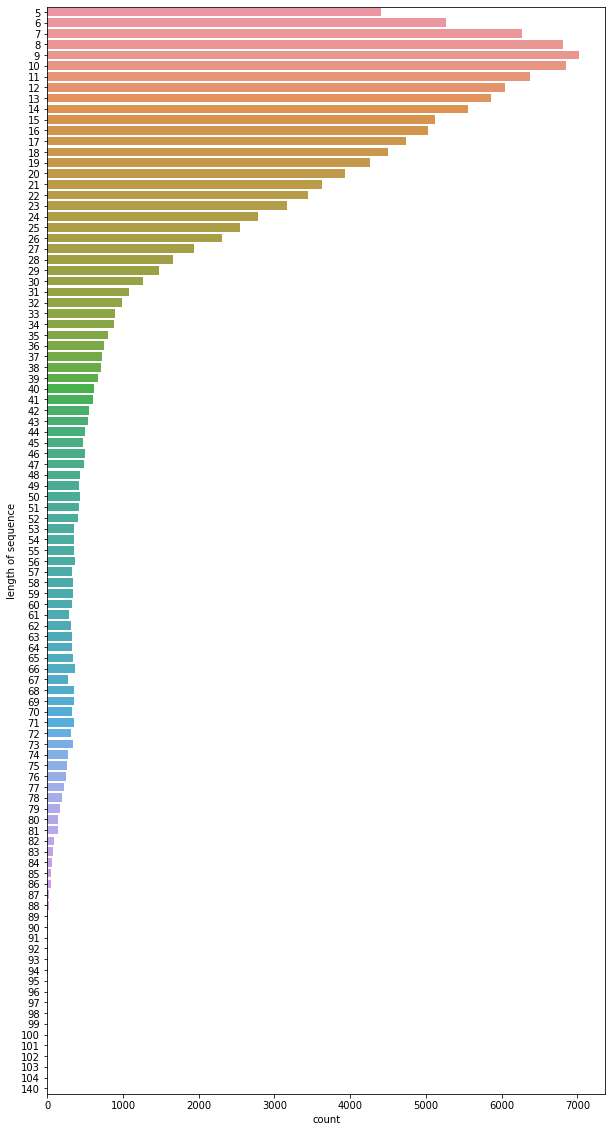

In [151]:
seq_lengths = list(map(len, train_inputs))

print("시퀀스 최대길이:", max(seq_lengths))
print("시퀀스 최소길이:", min(seq_lengths))
print("시퀀스 평균길이:", sum(seq_lengths) / len(seq_lengths))

_, ax = plt.subplots(figsize=(10, 20))
sns.countplot(y=seq_lengths, ax=ax)
plt.ylabel('length of sequence')
plt.xlabel('count')
plt.show()

In [119]:
train_inputs = keras.preprocessing.sequence.pad_sequences(train_inputs, maxlen=50, padding='post')

In [120]:
print('총 시퀀스 개수:', len(train_inputs))

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).reshape(-1, 1)

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

print('훈련 데이터 개수:', len(train_inputs), len(train_labels))
print('검증 데이터 개수:', len(val_inputs), len(val_labels))

총 시퀀스 개수: 135264
훈련 데이터 개수: 94684 94684
검증 데이터 개수: 40580 40580


# KoNLPy로 토큰화한 데이터로 훈련하기

In [121]:
def make_model(num_words, maxlen):
    inputs = keras.Input(shape=(maxlen,))
    x = layers.Embedding(num_words, 16, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(16))(x)
    outputs = layers.Dense(1, kernel_initializer='glorot_normal', activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [122]:
model = make_model(num_words, 50)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 16)            128000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 132,257
Trainable params: 132,257
Non-trainable params: 0
_________________________________________________________________


In [123]:
callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_KoNLPy.keras',
                                    save_best_only=True),
    #keras.callbacks.EarlyStopping(patience=5,
    #                              restore_best_weights=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

Epoch 1/20
185/185 [==============================] - 23s 38ms/step - loss: 0.4839 - accuracy: 0.7827 - val_loss: 0.3936 - val_accuracy: 0.8319
Epoch 2/20
185/185 [==============================] - 3s 16ms/step - loss: 0.3607 - accuracy: 0.8470 - val_loss: 0.3634 - val_accuracy: 0.8445
Epoch 3/20
185/185 [==============================] - 3s 16ms/step - loss: 0.3382 - accuracy: 0.8559 - val_loss: 0.3573 - val_accuracy: 0.8453
Epoch 4/20
185/185 [==============================] - 3s 15ms/step - loss: 0.3274 - accuracy: 0.8605 - val_loss: 0.3543 - val_accuracy: 0.8465
Epoch 5/20
185/185 [==============================] - 3s 16ms/step - loss: 0.3200 - accuracy: 0.8644 - val_loss: 0.3540 - val_accuracy: 0.8473
Epoch 6/20
185/185 [==============================] - 3s 15ms/step - loss: 0.3143 - accuracy: 0.8667 - val_loss: 0.3510 - val_accuracy: 0.8483
Epoch 7/20
185/185 [==============================] - 3s 16ms/step - loss: 0.3084 - accuracy: 0.8701 - val_loss: 0.3503 - val_accuracy: 0.848

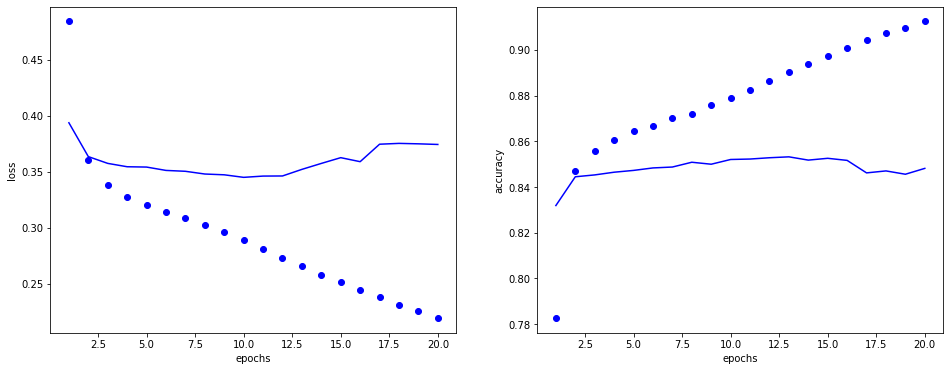

In [124]:
losses = history.history['loss']
val_losses = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(losses) + 1)

_, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(epochs, losses, 'bo', label='Training losses')
axs[0].plot(epochs, val_losses, 'b', label='Validation losses')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')

axs[1].plot(epochs, acc, 'bo', label='Training accuracy')
axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')

plt.show()

# KoNLPy로 토큰화한 데이터 모델 테스트

In [127]:
test_df = pd.read_csv('ratings_test.txt', sep='\t')

_test_corpus, _test_labels = preprocessing(test_df)
    
_test_corpus = konlpy_tokenizer.texts_to_sequences(_test_corpus)
test_inputs = keras.preprocessing.sequence.pad_sequences(_test_corpus, maxlen=50, padding='post')
test_labels = np.array(_test_labels).reshape(-1, 1)

/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


In [128]:
model = keras.models.load_model('NaverMovie_KoNLPy.keras')
print('KoNLPy 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

1562/1562 [==============================] - 43s 25ms/step - loss: 0.6085 - accuracy: 0.6498
KoNLPy 검증 정확도: 0.6497657895088196


# SentencePiece로 토큰화하기

In [131]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --model_type=bpe --vocab_size={} --max_sentence_length=9999'.format('train_corpus.txt', vocab_size)    
)

In [132]:
with open("./korean_spm.vocab", 'r') as f:
    vocab = f.readlines()

sp_index_word = {}

for idx, line in enumerate(vocab):
    word = line.split("\t")[0]
    sp_index_word.update({idx:word})

In [133]:
for i in range(1, 21):
    print(sp_index_word[i])

<s>
</s>
▁.
영화
▁영화
▁이
▁!
▁아
▁그
▁,
▁보
▁재
▁?
ᄏᄏ
▁정
니다
▁나
는데
▁다
너무


In [134]:
print(len(sp_index_word))

8000


/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


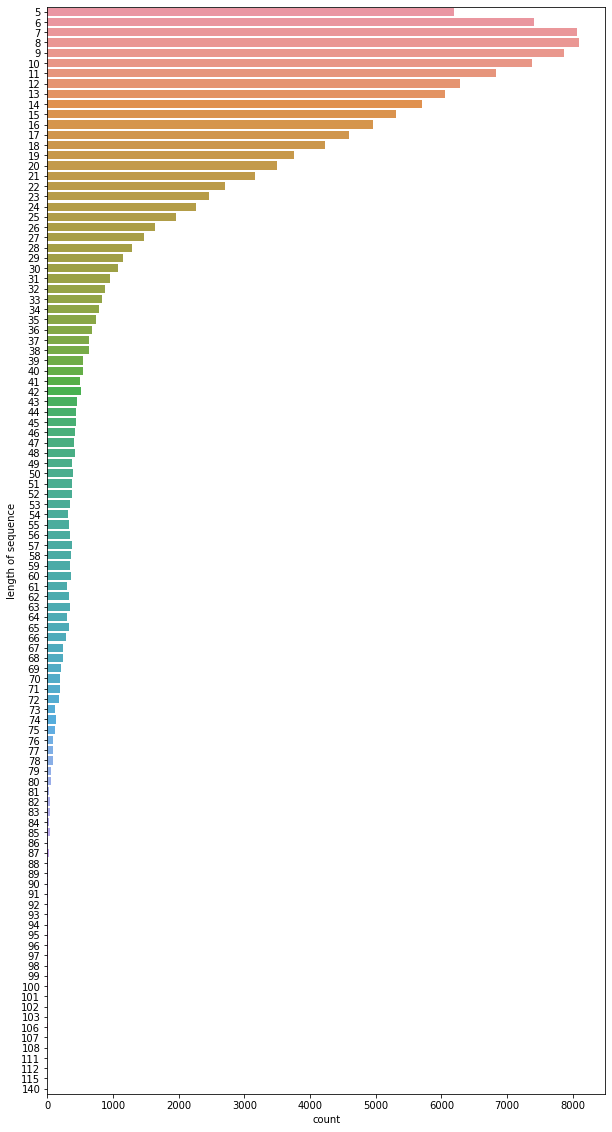

In [152]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

_corpus, _labels = preprocessing(train_df)

def sp_tokenizer(s, corpus, labels, padding='post', show_freq=True):
    sequences = []
    targets = []

    for i, text in enumerate(corpus):
        sequence = s.EncodeAsIds(text)
        if len(sequence) < 5:
            continue
        sequences.append(sequence)
        targets.append(labels[i])
    
    if show_freq:
        seq_lengths = list(map(len, sequences))
        _, ax = plt.subplots(figsize=(10, 20))
        sns.countplot(y=seq_lengths, ax=ax)
        ax.set_ylabel('length of sequence')
        ax.set_xlabel('count')
        plt.show()
    
    sequences = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=70, padding=padding)
    return sequences, np.array(targets)

train_inputs, train_labels = sp_tokenizer(s, _corpus, _labels)

In [153]:
print('총 시퀀스 개수:', len(train_inputs))

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).astype('float32')

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

print('훈련 데이터 개수:', len(train_inputs), len(train_labels))
print('검증 데이터 개수:', len(val_inputs), len(val_labels))

총 시퀀스 개수: 134617
훈련 데이터 개수: 94231 94231
검증 데이터 개수: 40386 40386


# SentencePiece로 토큰화된 데이터 학습하기

In [139]:
model = make_model(vocab_size, 70)

callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_SentencePiece.keras',
                                    save_best_only=True),
    #keras.callbacks.EarlyStopping(patience=5,
    #                              restore_best_weights=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

Epoch 1/20
185/185 [==============================] - 83s 353ms/step - loss: 0.4957 - accuracy: 0.7820 - val_loss: 0.3988 - val_accuracy: 0.8296
Epoch 2/20
185/185 [==============================] - 59s 321ms/step - loss: 0.3504 - accuracy: 0.8515 - val_loss: 0.3723 - val_accuracy: 0.8374
Epoch 3/20
185/185 [==============================] - 60s 326ms/step - loss: 0.3246 - accuracy: 0.8604 - val_loss: 0.3779 - val_accuracy: 0.8335
Epoch 4/20
185/185 [==============================] - 59s 321ms/step - loss: 0.3138 - accuracy: 0.8663 - val_loss: 0.3537 - val_accuracy: 0.8461
Epoch 5/20
185/185 [==============================] - 61s 328ms/step - loss: 0.3072 - accuracy: 0.8685 - val_loss: 0.3589 - val_accuracy: 0.8452
Epoch 6/20
185/185 [==============================] - 60s 323ms/step - loss: 0.3015 - accuracy: 0.8713 - val_loss: 0.3511 - val_accuracy: 0.8472
Epoch 7/20
185/185 [==============================] - 60s 326ms/step - loss: 0.2959 - accuracy: 0.8737 - val_loss: 0.3519 - val_ac

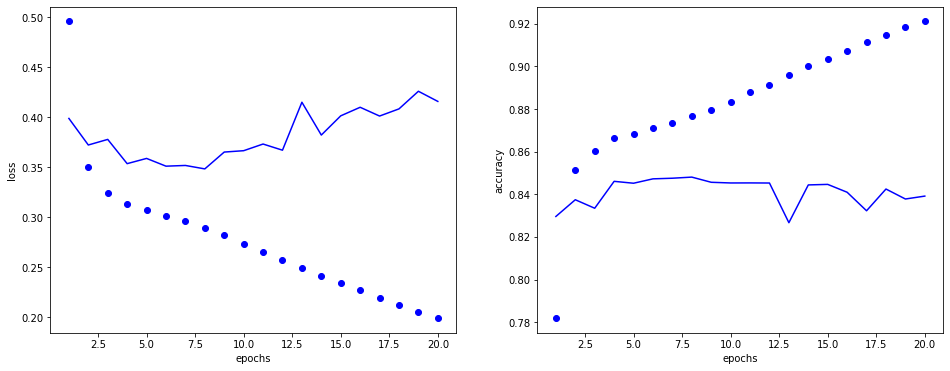

In [140]:
losses = history.history['loss']
val_losses = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(losses) + 1)

_, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(epochs, losses, 'bo', label='Training losses')
axs[0].plot(epochs, val_losses, 'b', label='Validation losses')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')

axs[1].plot(epochs, acc, 'bo', label='Training accuracy')
axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')

plt.show()

/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


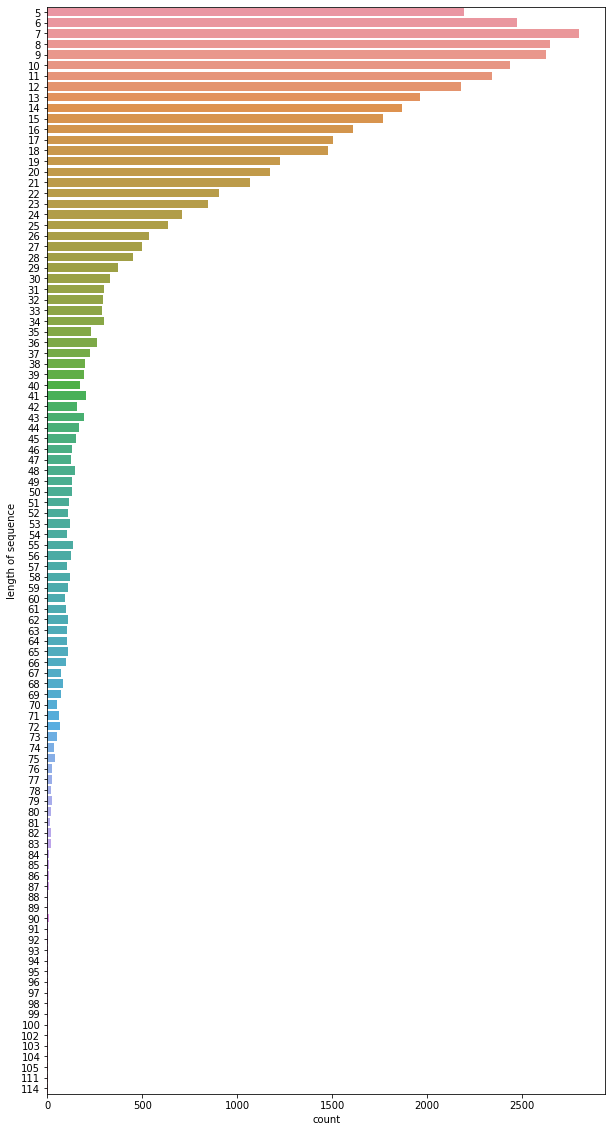

In [142]:
_test_corpus, _test_labels = preprocessing(test_df)

test_inputs, test_labels = sp_tokenizer(s, _test_corpus, _test_labels)

In [143]:
model = keras.models.load_model('NaverMovie_SentencePiece.keras')
print('SentencePiece 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

1412/1412 [==============================] - 31s 17ms/step - loss: 0.3544 - accuracy: 0.8457
SentencePiece 검증 정확도: 0.8456702828407288


동일한 모델에서 SentencePiece와 BPE를 통해 토큰화한 데이터셋이 모델 학습에 더 좋았음을 확인함

# SentencePiece 실험

In [144]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_unigram --vocab_size={} --max_sentence_length=9999'.format('train_corpus.txt', vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_bpe --model_type=bpe --vocab_size={} --max_sentence_length=9999'.format('train_corpus.txt', vocab_size)    
)

## Unigram, pre-padding 

In [154]:
s = spm.SentencePieceProcessor()
s.Load('naver_unigram.model')

_corpus, _labels = preprocessing(train_df)
train_inputs, train_labels = sp_tokenizer(s, _corpus, _labels, padding='pre', show_freq=False)

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).reshape(-1, 1)

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


In [156]:
model = make_model(vocab_size, 70)

callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_SentencePiece_unigram_pre.keras',
                                    save_best_only=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

Epoch 1/20
184/184 [==============================] - 74s 365ms/step - loss: 0.5115 - accuracy: 0.7689 - val_loss: 0.3894 - val_accuracy: 0.8337
Epoch 2/20
184/184 [==============================] - 61s 330ms/step - loss: 0.3503 - accuracy: 0.8508 - val_loss: 0.3569 - val_accuracy: 0.8469
Epoch 3/20
184/184 [==============================] - 59s 322ms/step - loss: 0.3226 - accuracy: 0.8624 - val_loss: 0.3524 - val_accuracy: 0.8478
Epoch 4/20
184/184 [==============================] - 61s 330ms/step - loss: 0.3114 - accuracy: 0.8671 - val_loss: 0.3497 - val_accuracy: 0.8497
Epoch 5/20
184/184 [==============================] - 59s 323ms/step - loss: 0.3046 - accuracy: 0.8718 - val_loss: 0.3481 - val_accuracy: 0.8500
Epoch 6/20
184/184 [==============================] - 60s 323ms/step - loss: 0.2998 - accuracy: 0.8727 - val_loss: 0.3498 - val_accuracy: 0.8500
Epoch 7/20
184/184 [==============================] - 59s 322ms/step - loss: 0.2947 - accuracy: 0.8753 - val_loss: 0.3470 - val_ac

/tmp/ipykernel_47/408831121.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document'] = df['document'].apply(lambda s: s.replace(p, ' ' + p + ' '))


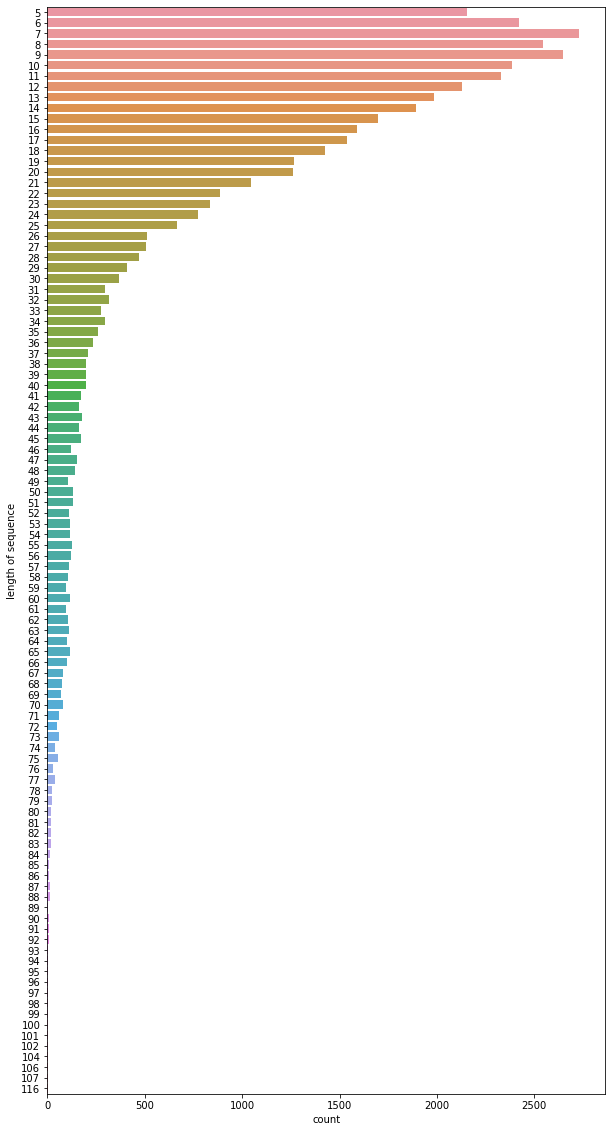

1387/1410 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8443

In [ ]:
_test_corpus, _test_labels = preprocessing(test_df)
test_inputs, test_labels = sp_tokenizer(s, _test_corpus, _test_labels)

model = keras.models.load_model('NaverMovie_SentencePiece_unigram_pre.keras')
print('SentencePiece 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

## Unigram, post-padding 

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('naver_unigram.model')

_corpus, _labels = preprocessing(train_df)
train_inputs, train_labels = sp_tokenizer(s, _corpus, _labels, padding='post', show_freq=False)

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).reshape(-1, 1)

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

In [ ]:
model = make_model(vocab_size, 70)

callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_SentencePiece_unigram_post.keras',
                                    save_best_only=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

In [ ]:
_test_corpus, _test_labels = preprocessing(test_df)
test_inputs, test_labels = sp_tokenizer(s, _test_corpus, _test_labels)

model = keras.models.load_model('NaverMovie_SentencePiece_unigram_post.keras')
print('SentencePiece 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

## BPE, pre-padding

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('naver_bpe.model')

_corpus, _labels = preprocessing(train_df)
train_inputs, train_labels = sp_tokenizer(s, _corpus, _labels, padding='pre', show_freq=False)

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).reshape(-1, 1)

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

In [ ]:
model = make_model(vocab_size, 70)

callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_SentencePiece_bpe_pre.keras',
                                    save_best_only=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

In [ ]:
_test_corpus, _test_labels = preprocessing(test_df)
test_inputs, test_labels = sp_tokenizer(s, _test_corpus, _test_labels)

model = keras.models.load_model('NaverMovie_SentencePiece_bpe_pre.keras')
print('SentencePiece 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

## BPE, post-padding 

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('naver_bpe.model')

_corpus, _labels = preprocessing(train_df)
train_inputs, train_labels = sp_tokenizer(s, _corpus, _labels, padding='post', show_freq=False)

num_train = int(len(train_inputs) * 0.7)
train_labels = np.array(train_labels).reshape(-1, 1)

val_inputs = train_inputs[num_train:]
val_labels = train_labels[num_train:]
train_inputs = train_inputs[:num_train]
train_labels = train_labels[:num_train]

In [ ]:
model = make_model(vocab_size, 70)

callbacks = [
    keras.callbacks.ModelCheckpoint('NaverMovie_SentencePiece_bpe_post.keras',
                                    save_best_only=True),
]

history = model.fit(train_inputs, train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_inputs, val_labels),
                    callbacks=callbacks)

In [ ]:
_test_corpus, _test_labels = preprocessing(test_df)
test_inputs, test_labels = sp_tokenizer(s, _test_corpus, _test_labels)

model = keras.models.load_model('NaverMovie_SentencePiece_bpe_post.keras')
print('SentencePiece 테스트 정확도:', model.evaluate(test_inputs, test_labels)[1])

## 실험 결과
- pre-padding vs post-padding
    - pre-padding한 결과가 더 좋았다
        - 감정 분석에 중요한 토큰이 뒤에서 등장한다
- unigram vs BPE
    - BPE 결과가 더 좋았다